In [ ]:
# Using:
# - Python 3.8.8
# - PyTorch 1.8.1

In [11]:
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Generative model

### Data import

In [6]:
def get_dataset():
    with open("data.json", "r") as read_file:
        data = json.load(read_file)
        
        pos = np.array(list(map(lambda x: [
            x['position']['x'],
            x['position']['y'],
            x['angle']
        ], data)))
        
                
        ranges = np.array(list(map(lambda x: x['laser_ranges'], data)))        
        ranges[ranges == np.inf] = 15  # replaces infinity values with 20
        
        # Ranges in all samples are prefixed and sufixed with 22 constant values (close to 0)
        trim_size = 22
        for i in range(0, trim_size):
            ranges = np.delete(ranges, 0, axis=1)
        for i in range(0, trim_size):
            ranges = np.delete(ranges, len(ranges[0]) - 1, axis=1)
        
    return pos, ranges

In [53]:
pos, ranges = get_dataset()

### Data visualization

In [8]:
def gen_arrow_head_marker(rot):
    arr = np.array([[.1, .3], [.1, -.3], [1, 0]])  # arrow shape
    angle = rot / 180 * np.pi
    rot_mat = np.array([
        [np.cos(angle), np.sin(angle)],
        [-np.sin(angle), np.cos(angle)]
        ])
    arr = np.matmul(arr, rot_mat)  # rotates the arrow

    # scale
    x0 = np.amin(arr[:, 0])
    x1 = np.amax(arr[:, 0])
    y0 = np.amin(arr[:, 1])
    y1 = np.amax(arr[:, 1])
    scale = np.amax(np.abs([x0, x1, y0, y1]))

    arrow_head_marker = mpl.path.Path(arr)
    return arrow_head_marker, scale

In [9]:
ranges_len = len(ranges[0])
def range_angle(idx):
    return -10 + (idx * 200 / ranges_len)

def prettify_ranges(ranges):
    ranges_plot = []
    for i, val in enumerate(ranges):
        x, y = (0, 0)

        # find the end point    
        endy = y + val * math.sin(math.radians(range_angle(i)))
        endx = val * math.cos(math.radians(range_angle(i)))

        ranges_plot.append([endx, endy])
    
    return np.array(ranges_plot)

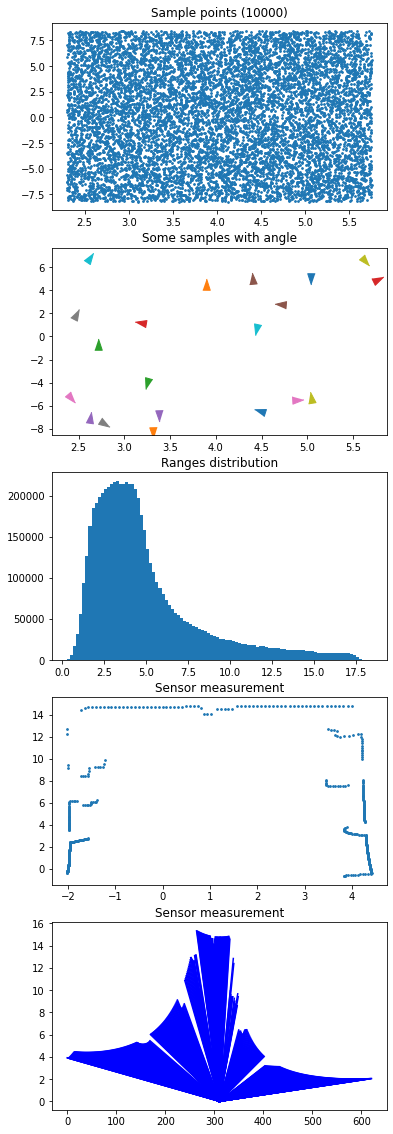

In [54]:
fig, axs = plt.subplots(5)
fig.set_figheight(20)

axs[0].set_title('Sample points ({length})'.format(length=len(pos)))
axs[0].scatter(pos[:, 0], pos[:, 1], s=3);

axs[1].set_title('Some samples with angle')
for i in range(20):
    marker, scale = gen_arrow_head_marker(math.degrees(pos[i][2]))
    markersize = 25
    axs[1].scatter(pos[i][0], pos[i][1], marker=marker, s=(markersize*scale)**2)

all_ranges = np.concatenate(ranges).ravel()
axs[2].set_title('Ranges distribution')
axs[2].hist(all_ranges, bins=100)

ranges_plot = prettify_ranges(ranges[0])
axs[3].set_title('Sensor measurement')
axs[3].scatter(ranges_plot[:, 0], ranges_plot[:, 1], s=3);

axs[4].set_title('Sensor measurement')
for i in range(len(ranges[0])):
    axs[4].plot([len(ranges[0])/2, i], [0, ranges[0][i]], '-b')

### Data normalization

In [55]:
ranges_max = ranges.max()
ranges_min = ranges.min()
positions_max = [pos[:, 0].max(), pos[:, 1].max(), pos[:, 2].max()]
positions_min = [pos[:, 0].min(), pos[:, 1].min(), pos[:, 2].min()]

def normalize_ranges(ranges_matrix):
    ranges_matrix = (ranges_matrix - ranges_min) / (ranges_max - ranges_min)
    return ranges_matrix
    
def normalize_pos(positions):
    positions[:, 0] = (positions[:, 0] - positions_min[0]) / (positions_max[0] - positions_min[0])
    positions[:, 1] = (positions[:, 1] - positions_min[1]) / (positions_max[1] - positions_min[1])
    positions[:, 2] = (positions[:, 2] - positions_min[2]) / (positions_max[2] - positions_min[2])
    return positions

def unormalize_ranges(ranges):
    return ranges * (ranges_max - ranges_min) + ranges_min;

def unnormalize_pos(positions):
    positions[:, 0] = positions[:, 0] * (positions_max[0] - positions_min[0]) + positions_min[0]
    positions[:, 1] = positions[:, 1] * (positions_max[1] - positions_min[1]) + positions_min[1]
    positions[:, 2] = positions[:, 2] * (positions_max[2] - positions_min[2]) + positions_min[2]
    return positions

Train data points: 8000
Test data points: 2000
Length of ranges per data point: 622


(array([ 87.,  82., 107.,  85.,  97.,  90.,  98.,  83., 101.,  93.,  89.,
         91.,  93., 109., 108.,  94., 120., 100., 104., 109., 107., 102.,
         98.,  96., 100., 123.,  95.,  97., 110., 122.,  86., 112., 123.,
         78., 109.,  96.,  91.,  84., 101.,  92., 102., 109., 102., 104.,
         92.,  94., 100.,  98.,  97.,  95., 102., 114., 121.,  82.,  91.,
         93., 105., 100., 111.,  96., 106., 125.,  91.,  94., 105.,  92.,
        119.,  87.,  92.,  91.,  94.,  90.,  77., 110., 107.,  95., 109.,
        119., 102., 100., 106.,  92., 105.,  91., 106., 109.,  81., 100.,
        116.,  97.,  91., 137., 111., 100., 102.,  95.,  93.,  90., 101.,
        102.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.

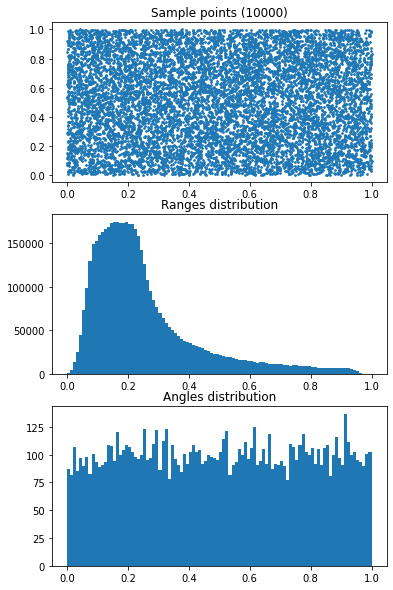

In [56]:
# Splitting dataset into test and train
dataset_size = len(pos)
train_data_percentage = 0.8
train_upto_idx = int(dataset_size * train_data_percentage)

train_pos = pos[0 : train_upto_idx]
train_ranges = ranges[0 : train_upto_idx]
test_pos = pos[train_upto_idx : dataset_size]
test_ranges = ranges[train_upto_idx : dataset_size]


print('Train data points: {length}'.format(length=len(train_pos)))
print('Test data points: {length}'.format(length=len(test_pos)))
print('Length of ranges per data point: {length}'.format(length=len(ranges[0])))


# Normalizing data
train_pos = normalize_pos(train_pos)
train_ranges = normalize_ranges(train_ranges)
test_pos = normalize_pos(test_pos)
test_ranges = normalize_ranges(test_ranges)

# Visualizing normalized data
fig, axs = plt.subplots(3)
fig.set_figheight(10)

axs[0].set_title('Sample points ({length})'.format(length=len(pos)))
axs[0].scatter(pos[:, 0], pos[:, 1], s=3);

axs[1].set_title('Ranges distribution')
axs[1].hist(np.concatenate(train_ranges).ravel(), bins=100)

axs[2].set_title('Angles distribution')
axs[2].hist(pos[:, 2], bins=100)

### Transposed Convolutional Neural Network

In [57]:
class ConvTransposeNet(nn.Module):
    def __init__(self):
        super(ConvTransposeNet, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(3, 99),
            nn.ReLU(),
            nn.Linear(99, 198),
            nn.ReLU(),
            
            nn.ConvTranspose1d(in_channels=1, out_channels = 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.ReLU(),
            nn.Conv1d(in_channels=1, out_channels = 1, kernel_size=1, stride=1, padding=0, bias=False),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=1, out_channels = 1, kernel_size=22, stride=3, padding=0, bias=False),
            nn.ReLU(),
            nn.Conv1d(in_channels=1, out_channels = 1, kernel_size=1, stride=1, padding=0, bias=False),
            nn.ReLU(),
        )
        
        
    def forward(self, x):     
        out = self.layers(x)
        
        return out

In [61]:
torch.set_default_tensor_type('torch.DoubleTensor')

# Hyperparameters
num_epochs = 16
batch_size = 500
learning_rate = 0.002

train_tensor_dataset = TensorDataset(torch.from_numpy(train_pos).double(), torch.from_numpy(train_ranges).double())
train_loader = DataLoader(train_tensor_dataset, batch_size=batch_size, shuffle=True)

test_tensor_dataset = TensorDataset(torch.from_numpy(test_pos).double(), torch.from_numpy(test_ranges).double())
test_loader = DataLoader(test_tensor_dataset, batch_size=batch_size, shuffle=False)

test_batch_pos, test_batch_ranges = next(iter(test_loader))
test_batch_pos.unsqueeze_(1)
test_batch_ranges.unsqueeze_(1)

tensor([[[0.1453, 0.1447, 0.1441,  ..., 0.2017, 0.2015, 0.2013]],

        [[0.3536, 0.3533, 0.3507,  ..., 0.6750, 0.6763, 0.6776]],

        [[0.1099, 0.1094, 0.1089,  ..., 0.2384, 0.2381, 0.2378]],

        ...,

        [[0.1133, 0.1144, 0.1148,  ..., 0.2174, 0.2174, 0.2173]],

        [[0.1014, 0.1008, 0.1003,  ..., 0.2151, 0.2146, 0.2143]],

        [[0.2465, 0.2491, 0.2517,  ..., 0.5563, 0.5524, 0.5535]]])

### Model training

Final error: 0.11970662296627743


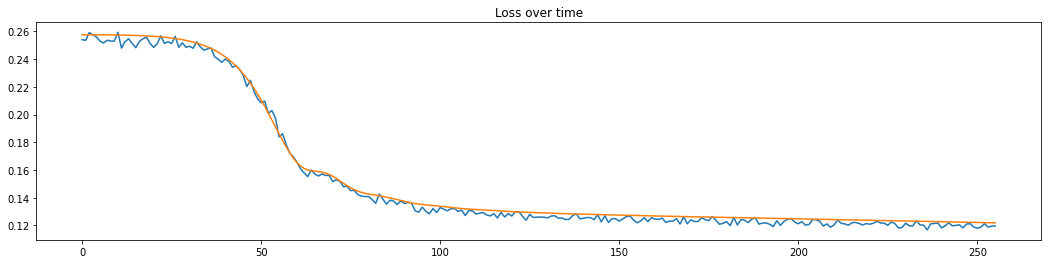

In [66]:
model = ConvTransposeNet()

# Loss and optimizer
# criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
loss_list = []
test_loss_list = []
for epoch in range(num_epochs):
    for i, (pos, ranges) in enumerate(train_loader):        
        pos.unsqueeze_(1) # adds one extra dimension to make it (batch_size, 1, 3) for the ConvTranspose1d
        ranges.unsqueeze_(1)
        
        # Forward pass
        outputs = model(pos)
        
        # Loss computation
        loss = criterion(outputs, ranges)
        loss_list.append(loss.item())        
        
        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        
        # Test loss computation        
        test_outputs = model(test_batch_pos)
        test_loss = criterion(test_outputs, test_batch_ranges)
        test_loss_list.append(test_loss.item())


fig2, axs2 = plt.subplots()
fig2.set_figwidth(18)
axs2.set_title('Loss over time')
axs2.plot(np.arange(len(loss_list)), loss_list);
axs2.plot(np.arange(len(test_loss_list)), test_loss_list);

print('Final error: {x}'.format(x=loss_list[-1]))

### Save model

In [51]:
torch.save(model.state_dict(), "model")

### Load model

In [11]:
model = ConvTransposeNet()
model.load_state_dict(torch.load("model"))
model.eval()

ConvTransposeNet(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=99, bias=True)
    (1): ReLU()
    (2): Linear(in_features=99, out_features=198, bias=True)
    (3): ReLU()
    (4): ConvTranspose1d(1, 1, kernel_size=(4,), stride=(1,), bias=False)
    (5): ReLU()
    (6): Conv1d(1, 1, kernel_size=(1,), stride=(1,), bias=False)
    (7): ReLU()
    (8): ConvTranspose1d(1, 1, kernel_size=(22,), stride=(3,), bias=False)
    (9): ReLU()
    (10): Conv1d(1, 1, kernel_size=(1,), stride=(1,), bias=False)
    (11): ReLU()
  )
)

### Model performance visualization

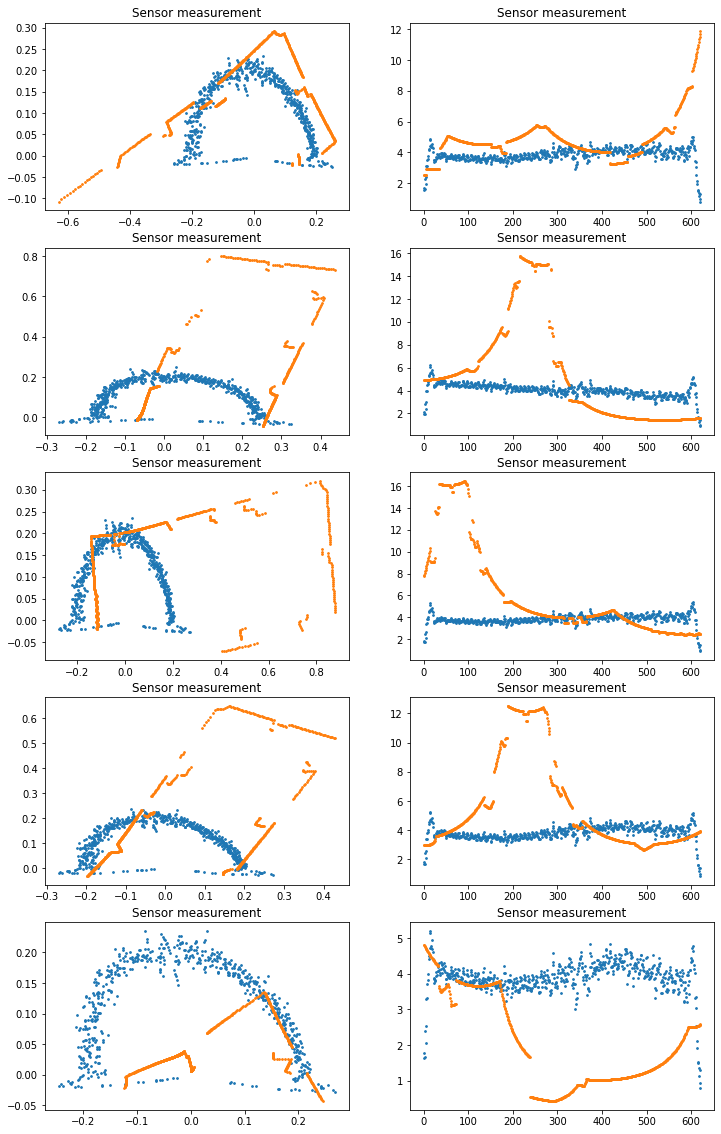

In [68]:
criterion = nn.L1Loss()
test_outputs = model(test_batch_pos)
test_loss = criterion(test_outputs, test_batch_ranges)

nr_plots = 5
fig3, axs3 = plt.subplots(nr_plots, 2)
fig3.set_figheight(nr_plots * 4)
fig3.set_figwidth(12)

for i in range(nr_plots):
    sample_idx = random.randint(0, len(test_outputs))
    single_output = test_outputs[sample_idx][0].detach().numpy()
    single_true_output = test_batch_ranges[sample_idx][0].detach().numpy()
    
    
    pred_ranges_prettified = prettify_ranges(single_output)
    true_ranges_prettified = prettify_ranges(single_true_output)
    axs3[i][0].set_title('Sensor measurement')
    axs3[i][0].scatter(pred_ranges_prettified[:, 0], pred_ranges_prettified[:, 1], s=3);
    axs3[i][0].scatter(true_ranges_prettified[:, 0], true_ranges_prettified[:, 1], s=3);
    
    axs3[i][1].set_title('Sensor measurement')
    axs3[i][1].scatter(np.arange(len(single_output)), unormalize_ranges(single_output), s=3);
    axs3[i][1].scatter(np.arange(len(single_true_output)), unormalize_ranges(single_true_output), s=3);
    

# Predictive coding model

In [14]:
def fep(belief_pos, real_ranges):
    input = Variable(belief_pos, requires_grad=True)

    # Generative model prediction (from internal state to sensory space)
    pred_ranges = model(input)

    # Prediction error (Free Energy)
    pred_error = real_ranges - pred_ranges   # torch.Size([1, 1, 622])        
    
    # Precision vector
    sigma = torch.tensor([1] * 622)   # torch.Size([622]) 

    # 
    dF_dg = (1/sigma) * pred_error  # torch.Size([1, 1, 622])

    # Sets gradient to zero
    input.grad=torch.zeros(input.size())
    
    # Backpagates the error
    pred_ranges.backward(torch.ones(pred_ranges.shape)*dF_dg,retain_graph=True)

    # Returns gradient
    return input.grad


def run(belief_pos, real_ranges, iterations):
    belief_hist = np.array([belief_pos.detach().numpy()[0][0]])
    
    for i in range(iterations - 1):
        belief_pos_dot = fep(belief_pos, real_ranges)
        belief_pos = torch.add(belief_pos, belief_pos_dot, alpha=0.005) # alpha = learning rate
        belief_hist = np.append(belief_hist, [belief_pos.detach().numpy()[0][0]], axis=0)
    
    return belief_hist

Sample idx: 140
Real pos: tensor([0.2782, 0.6434])
Initial belief of x: [ 5. -3.]
Final belief of x: [0.43563081 0.63724964]


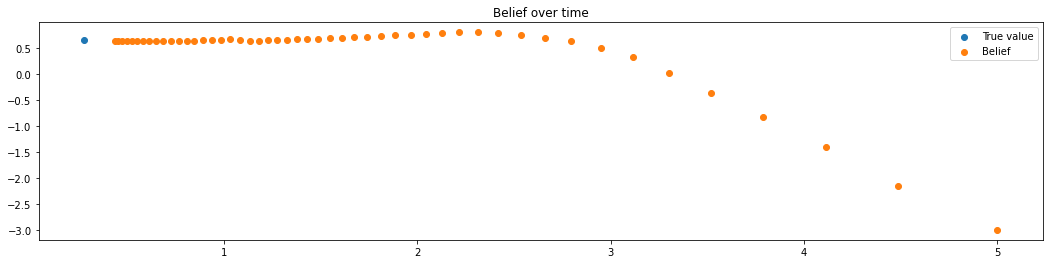

In [15]:
sample_idx = random.randint(0, len(test_batch_pos))  # random sample from the test set
real_pos = test_batch_pos[sample_idx]    # real position
real_ranges = test_batch_ranges[sample_idx]    # real measurement
belief_pos = torch.tensor([[[5.0, -3.0, 3.14]]])      # initial belief
iterations = 50

belief_hist = run(belief_pos, real_ranges, iterations)

print('Sample idx: {x}'.format(x=sample_idx))
print('Real pos: {x}'.format(x=real_pos[0]))
print('Initial belief of x: {x}'.format(x=belief_hist[0]))
print('Final belief of x: {x}'.format(x=belief_hist[-1]))

fig4, axs4 = plt.subplots()
fig4.set_figwidth(18)
axs4.set_title('Belief over time')
axs4.scatter(real_pos[0][0], real_pos[0][1], label='True value');
axs4.scatter(belief_hist[:, 0], belief_hist[:, 1], label='Belief');
axs4.legend();

## With same number of iterations

In [21]:
class comparison_sample:
    def __init__(self, inferred, true, ranges):
        self.amcl_inferred = inferred
        self.true = true
        self.ranges = ranges        
        
        self.ranges[self.ranges == np.inf] = 15 # replaces infinity values with 20
        # Ranges in all samples are prefixed and sufixed with 22 constant values (close to 0)
        trim_size = 22
        for i in range(0, trim_size):
            self.ranges = np.delete(self.ranges, 0, axis=1)
        for i in range(0, trim_size):
            self.ranges = np.delete(self.ranges, len(self.ranges[0]) - 1, axis=1)
            
        
        
    def set_model_inferred(self, inferred):
        self.model_inferred = inferred

def load_comparative_array(file):
    with open(file, "r") as read_file:
        data = json.load(read_file)
        
        data = np.array(list(map(lambda sample: comparison_sample(
            np.array(list(map(lambda x: [
                x['amcl']['x'],
                x['amcl']['y']
            ], sample))),
            
            np.array(list(map(lambda x: [
                x['true']['x'],
                x['true']['y']
            ], sample))),
            
            np.array(list(map(lambda x: x['laser'], sample)))
        ), data)))
        
    return data


stats_data = load_comparative_array('two_axis_static_stats_data_100.json')
model_initial_belief = torch.tensor([normalize_pos(np.array([[3.0, 0.0]]))])

    
for i in range(len(stats_data)):
    stats_sample = stats_data[i]    
    stat_ranges_normalized = normalize_ranges(stats_sample.ranges)
    stat_model = run(model_initial_belief, torch.tensor([stat_ranges_normalized[0]]), len(stats_sample.amcl_inferred))
    stat_model = unnormalize_pos(np.array(stat_model))
    stats_sample.set_model_inferred(stat_model)

    
# for i in range(len(stats_data)):
#     print(stats_data[i].model_inferred[0], stats_data[i].amcl_inferred[0])

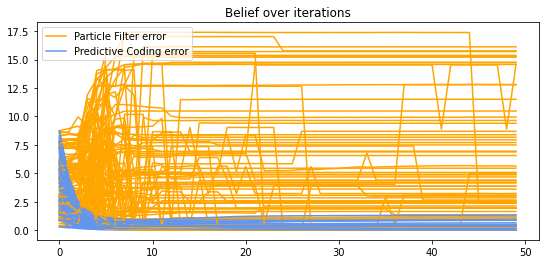

In [22]:
error_amcl = []
error_model = []

fig7, axs7 = plt.subplots()
fig7.set_figwidth(9)
for i in range(len(stats_data)):
    stats_sample = stats_data[i]
    diffs_particle = abs(stats_sample.amcl_inferred - stats_sample.true)
    diffs_model = abs(stats_sample.model_inferred - stats_sample.true)

    errors_particle = np.array(list(map(lambda x: math.sqrt(math.pow(x[0], 2) + math.pow(x[1], 2)), diffs_particle)))
    errors_model = np.array(list(map(lambda x: math.sqrt(math.pow(x[0], 2) + math.pow(x[1], 2)), diffs_model)))
    
    if i == 0:
        error_amcl = np.array([errors_particle])
        error_model = np.array([errors_model])
    else:
        error_amcl = np.append(error_amcl, [errors_particle], axis = 0)
        error_model = np.append(error_model, [errors_model], axis = 0)
    
    axs7.set_title('Belief over iterations')
    axs7.plot(np.arange(len(errors_particle)), errors_particle, color='orange', label='Particle Filter error');
    axs7.plot(np.arange(len(errors_model)), errors_model, color='cornflowerblue', label='Predictive Coding error');
    
axs7.legend(['Particle Filter error', 'Predictive Coding error'])

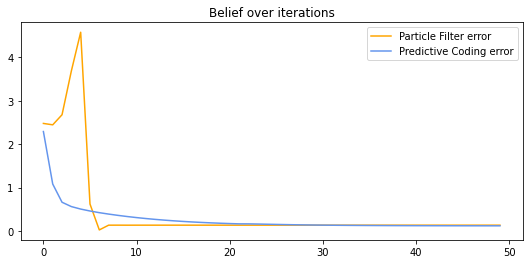

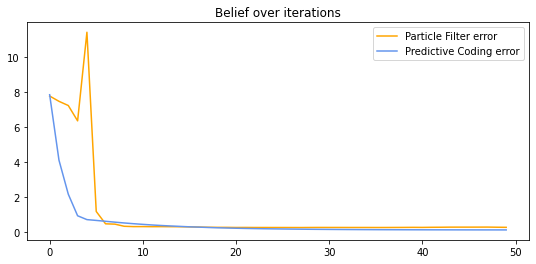

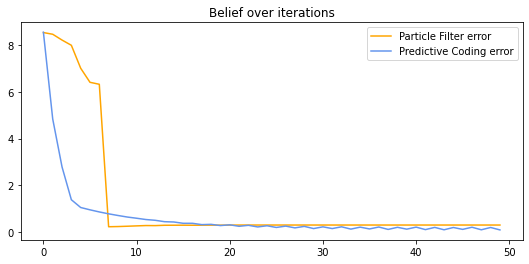

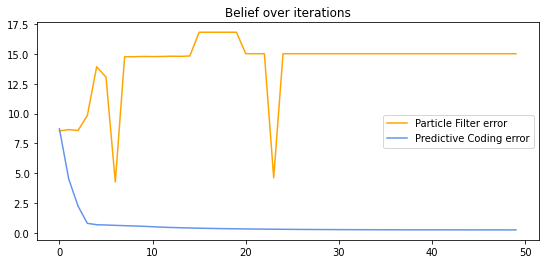

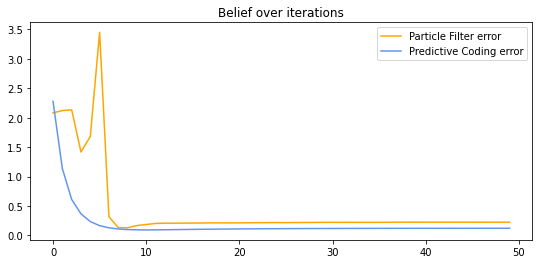

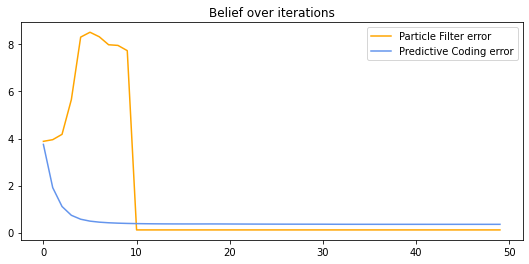

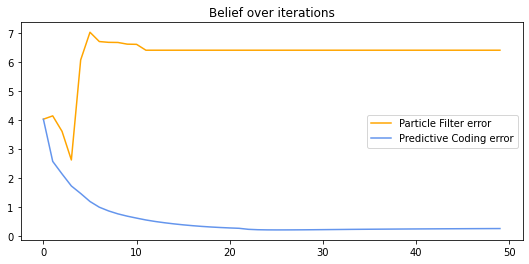

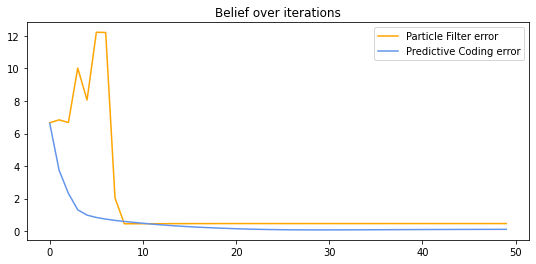

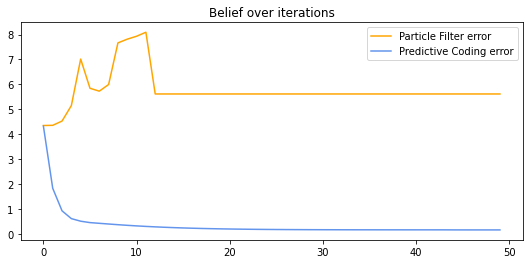

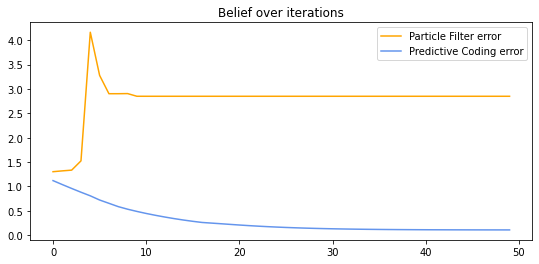

In [211]:
for i in range(len(stats_data)):
    stats_sample = stats_data[i]
    diffs_particle = abs(stats_sample.amcl_inferred - stats_sample.true)
    diffs_model = abs(stats_sample.model_inferred - stats_sample.true)

    errors_particle = np.array(list(map(lambda x: math.sqrt(math.pow(x[0], 2) + math.pow(x[1], 2)), diffs_particle)))
    errors_model = np.array(list(map(lambda x: math.sqrt(math.pow(x[0], 2) + math.pow(x[1], 2)), diffs_model)))
    
    
    fig7, axs7 = plt.subplots()
    fig7.set_figwidth(9)
    axs7.set_title('Belief over iterations')
    axs7.plot(np.arange(len(errors_particle)), errors_particle, color='orange', label='Particle Filter error');
    axs7.plot(np.arange(len(errors_model)), errors_model, color='cornflowerblue', label='Predictive Coding error');
    axs7.legend(['Particle Filter error', 'Predictive Coding error'])

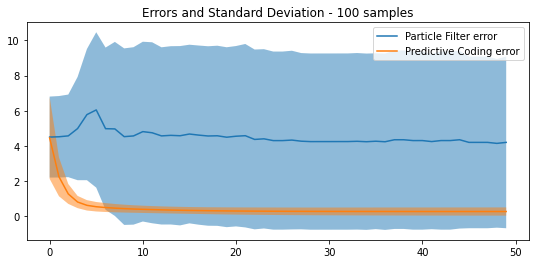

In [24]:
mean_amcl = np.mean(error_amcl, axis=0)
mean_model = np.mean(error_model, axis=0)
std_amcl = np.std(error_amcl, axis=0)
std_model = np.std(error_model, axis=0)

fig7, axs7 = plt.subplots()
fig7.set_figwidth(9)
axs7.set_title('Errors and Standard Deviation - {length} samples'.format(length=len(error_amcl)))
axs7.plot(mean_amcl, label='Particle Filter error')
axs7.fill_between(range(len(mean_amcl)), mean_amcl-std_amcl, mean_amcl+std_amcl, alpha = 0.5)
axs7.plot(mean_model, label='Predictive Coding error')
axs7.fill_between(range(len(mean_model)), mean_model-std_model, mean_model+std_model, alpha = 0.5)
axs7.legend()

## Moving sideways

In [63]:
amcl_inferred, true, ranges = load_comparative('two_axis_move_stats_data.json')

ranges_normalized = normalize_ranges(ranges)
model_inferred = [[3.0, 0.0]]

for i in range(int(len(ranges_normalized) / 3)):
    model_pred = run(torch.tensor([[model_inferred[-1]]]), torch.tensor([ranges_normalized[i * 3]]), 3)[-1]
    model_inferred.append(model_pred)
    model_inferred.append(model_pred)
    model_inferred.append(model_pred)

model_inferred = unnormalize_pos(np.array(model_inferred))
model_inferred = model_inferred[0:len(amcl_inferred)]

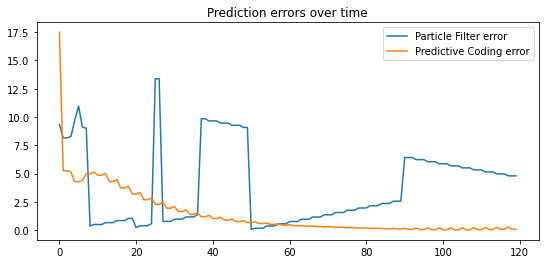

In [64]:
diffs_particle = abs(amcl_inferred - true)
diffs_model = abs(model_inferred - true)

errors_particle = np.array(list(map(lambda x: math.sqrt(math.pow(x[0], 2) + math.pow(x[1], 2)), diffs_particle)))
errors_model = np.array(list(map(lambda x: math.sqrt(math.pow(x[0], 2) + math.pow(x[1], 2)), diffs_model)))

fig6, axs6 = plt.subplots()
fig6.set_figwidth(9)
axs6.set_title('Prediction errors over time')
axs6.plot(np.arange(len(errors_particle)), errors_particle, label='Particle Filter error');
axs6.plot(np.arange(len(errors_model)), errors_model, label='Predictive Coding error');
axs6.legend()